Линейная регрессия
===========

In [49]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

### Предсказание цены домов в Альбукерке

- PRICE = продажная цена в сотнях долларов; 
- SQFT = площадь в квадратных футах; 
- AGE = возраст дома (количество лет); 
- FEATS = количество дополнительных удобств из 11 возможных: 
dishwasher, refrigerator, microwave, disposer, washer, intercom, 
skylight(s), compactor, dryer, handicap fit, cable TV access; 
- NE = дом расположен в престижном районе на северо-востоке 
города (1), или нет (0);
- CUST = тип постройки: был ли дом обычной постройки, или нет, 
- COR = как расположен дом, на углу (1) или нет (0). 
- TAX = величина налогов за владение домом ($).

In [50]:
df = pd.read_csv('Albuquerque Home Prices.txt', sep='\t')

In [51]:
df.head()

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13,7,1,1,0,1639
1,2080,2600,-9999,4,1,1,0,1088
2,2150,2664,6,5,1,1,0,1193
3,2150,2921,3,6,1,1,0,1635
4,1999,2580,4,4,1,1,0,1732


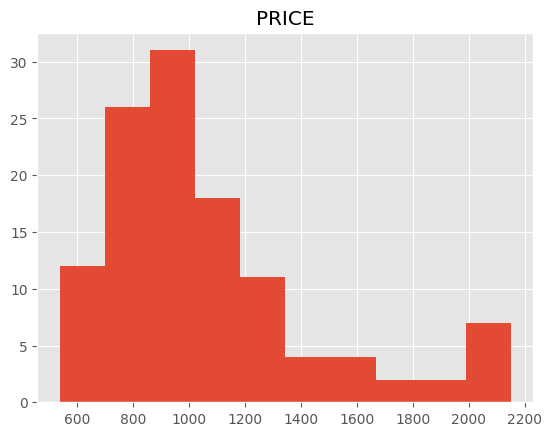

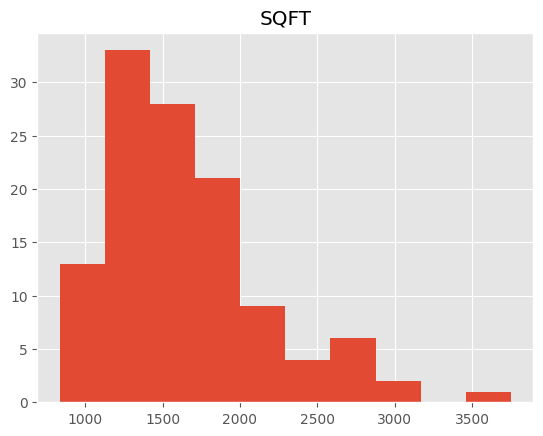

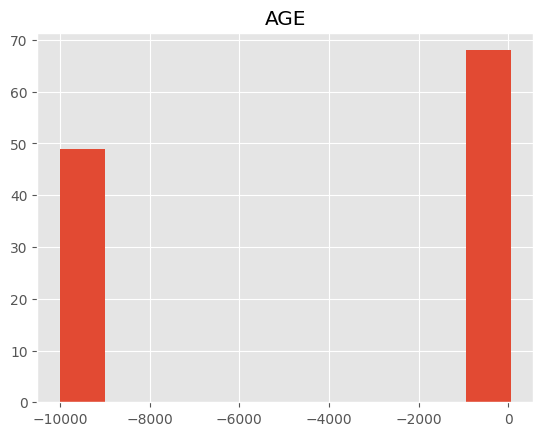

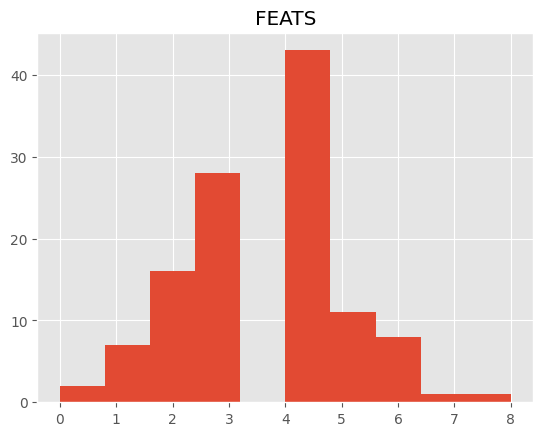

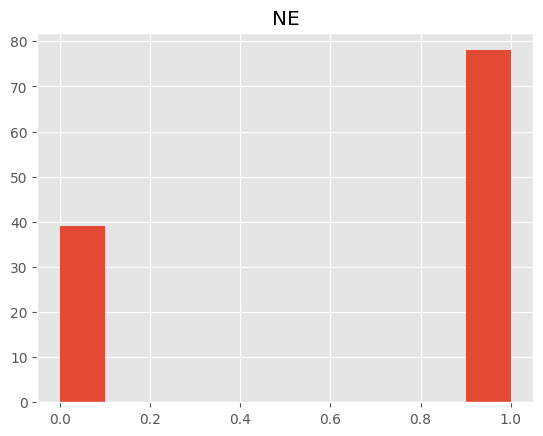

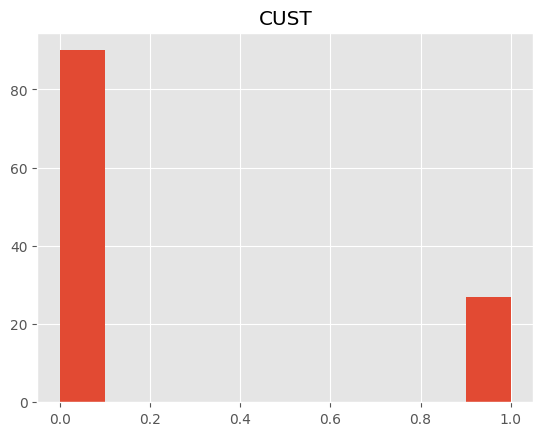

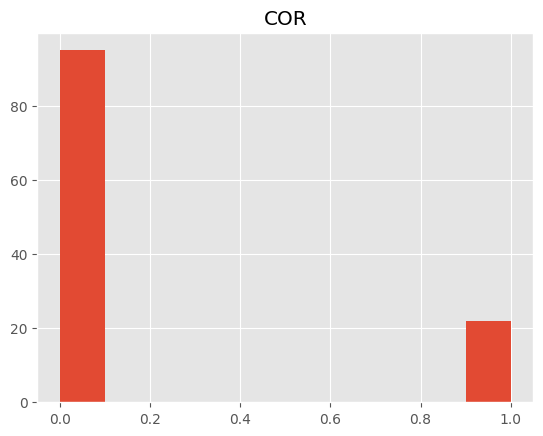

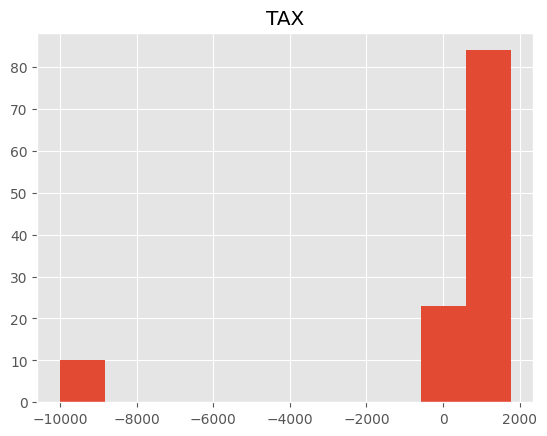

In [52]:
# Строим распределение всех признаков.
for i in df.columns:
    df[[i]].hist()

In [53]:
# Найдем минимальный возраст дома и минимальный налог.
print(df['TAX'].min())
print(df['AGE'].min())

-9999
-9999


In [54]:
# В прошлом пункте были получены испорченные данные.
# Выведем значение и его количество в стобцах AGE и TAX, чтобы посмотреть есть ли еще некорректные данные и оценить их количество.
print(df['TAX'].value_counts())
print(df['AGE'].value_counts())

-9999    10
 600      4
 668      2
 591      2
 750      2
         ..
 599      1
 566      1
 553      1
 626      1
 541      1
Name: TAX, Length: 96, dtype: int64
-9999    49
 4        8
 6        7
 7        6
 15       5
 5        4
 13       3
 16       3
 17       3
 40       2
 28       2
 25       2
 14       2
 8        2
 1        2
 3        2
 34       1
 22       1
 19       1
 20       1
 45       1
 30       1
 26       1
 23       1
 43       1
 46       1
 41       1
 53       1
 18       1
 2        1
 9        1
Name: AGE, dtype: int64


In [55]:
# Обнаружили, что в столбце TAX некорректное значение -9999 встречается 10 раз, в столбце AGE - 49 раз.
# Произведем замену данного значения на более корректное, в данном случае, NaN.
df = df.replace(-9999, np.nan)

In [56]:
df.head()

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13.0,7,1,1,0,1639.0
1,2080,2600,NaN,4,1,1,0,1088.0
2,2150,2664,6.0,5,1,1,0,1193.0
3,2150,2921,3.0,6,1,1,0,1635.0
4,1999,2580,4.0,4,1,1,0,1732.0


Прежде, чем строить модель, нужно решить вопрос с пропущенными значениями. Сначала посчитаем, сколько строчек их содержат.

In [57]:
df.shape

(117, 8)

In [58]:
print('Rows in the data frame: {0}'.format(len(df)))
print('Rows without NAN: {0}'.format(len(df.dropna(how='any'))))

Rows in the data frame: 117
Rows without NAN: 66


Таким образом, около половины наших данных содержат хотя бы одно пропущенное значение. Учитывая то, что данных относительно мало, выбрасывать все такие строчки, было бы слишком расточительно.

Попробуем копнуть глубже и посмотреть на распределение пропущенных значений по колонкам.

Функция ```DataFrame.apply``` применяет указанную функцию ко всей таблице. Первый аргумент -- применяемая функция, второй аргумент -- направление её применения (0 -- применить к колонкам, 1 -- к строчкам).

In [59]:
df.apply(lambda x: sum(x.isnull()), axis=0)

PRICE     0
SQFT      0
AGE      49
FEATS     0
NE        0
CUST      0
COR       0
TAX      10
dtype: int64

Для определения функции здесь использовано так называемое лямбда-выражение (лямбда-функция). Это способ записать короткую функцию в одну строчку, не задавая её имени. В данном случае такое лямбда-выражение эквивалентно следующему определению функции:

`
def f(x):
    return sum(x.isnull())
`

Таким образом, видим, что источниками пропущенных значений являются колонки ```AGE``` и ```TAX```. Раз в колонке ```AGE``` так много пропусков, то проще её будет убрать из анализа, чем пытаться заделать эти дырки.

In [60]:
del(df['AGE']) # удалили столбец AGE

А колонку ```TAX``` можно попробовать починить. Чтобы это сделать, сначала посмотрим, как выглядит распределение этой колонки.

<AxesSubplot: >

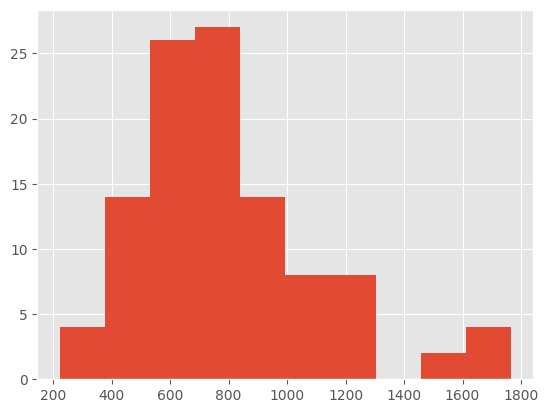

In [61]:
df['TAX'].hist() # строим гистограмму распределения TAX

Раз распределение похоже на нормальное, то можно заменить пропуски на среднее значение этой колонки. Для этого в pandas есть функция ```Series.fillna```, которая заменяет все пропущенные в колонке значения на заданное.

In [62]:
df['TAX'] = df['TAX'].fillna(df['TAX'].mean()) # заменили все пропущенные значения на среднее

<AxesSubplot: >

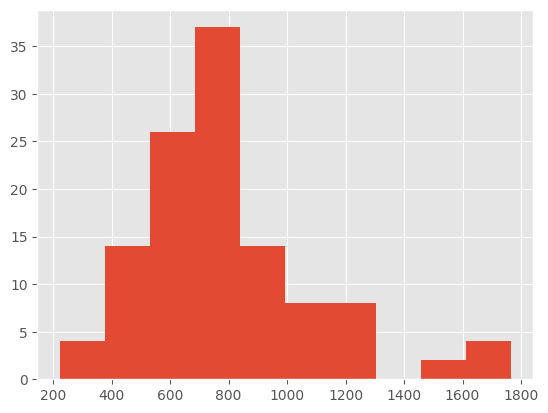

In [63]:
df['TAX'].hist() # строим гистограмму распределения TAX

Убедимся, что все проблемы с пропусками устранены. Длина таблицы с пропусками равна длине исходного датасета.

In [64]:
len(df.dropna())
# Изначально наши данные содержали некорректные значения, которые мы обнаружили поиском минимума по столбцам.
# Данные некорректные значения были заменены на значение NaN, которое является корректным в данном случае.
# Дальше мы оценили, сколько данных потеряем, если просто удалим строки содержащие NaN.
# Это оказалось больше половины исходных данных, что является неприемлемым.
# Поэтому, оценив по столбцам распределение значений NaN, приняли решение, что столбец AGE проще исключить из анализа, а данные в колонке TAX дополнить средним значением, т.к. распределение похоже на нормальное.

117

#### Построение модели

Теперь можно переходить непосредственно к построению модели.

In [65]:
from sklearn.linear_model import LinearRegression

In [66]:
# Разабъем данные на входные признаки (X) и прогнозируемое значение (y).
X = df.drop('PRICE', axis=1)
y = df['PRICE']

In [67]:
# Создадим и заполним модель линейной регрессии.
model = LinearRegression()
model.fit(X, y)

LinearRegression()

Считаем качество модели (коэффициент $R^2$).

In [68]:
print('R^2: {0}'.format(model.score(X, y)))
# Коэффициент R^2 показывает качество обучения модели. Лучшее значение = 1.0. В нашем же случае R^2=0.8022436, означает, что модель довольно неполохо предсказывает истинное значение y.

R^2: 0.8022436103807492


Выведем регрессионные коэффициенты от метода ```model.coef_``` и свободный член от метода ```model.intercept_```.

In [69]:
coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist()),
                    columns=['predictor', 'coef'])
coef
# коэффициенты coef позволяют по набору признаков предсказать цену дома, то есть X*coef = y
# intercept является свободным членом, необходимый для линейной регрессии

,predictor,coef
0,intercept,83.175919
1,SQFT,0.291978
2,FEATS,12.176743
3,NE,8.011604
4,CUST,133.014342
5,COR,-65.800841
6,TAX,0.541942


In [44]:
PRICE = 83.17+SQFT*0.29+FEATS*12.17+..+TAX*0.54 # предсказание цены дома в зависимости от признаков SQFT, FEATS, TAX и др.
PRICE1 = 83.17+(SQFT+1)*0.29+FEATS*12.17+..     # предсказание цены дома с площадью на 1 квадратный фут больше существующего
(PRICE1 - PRICE) = 0.29 # 1 sqft = 29$
# Получили, что 1 кв. фут стоит 29$

PRICE2 = 83.17+SQFT*0.29+FEATS*12.17+..+(TAX+0.1%)*0.54 # предсказание цены дома с повышенным налогом на 0.1%

SyntaxError: invalid syntax (2611420211.py, line 1)

К сожалению, в ```sklearn``` не предусмотрена процедура определения статистической значимости регрессионных коэффициентов. Поэтому нужно это делать либо руками, вооружившись знанием о распределении коэффициентов, либо воспользовавшись моделью из пакета ```statsmodels```.

In [70]:
from scipy import stats

def regression_coef(model, X, y):
    coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist()),
                    columns=['predictor', 'coef']) 
    X1 = np.append(np.ones((len(X),1)), X, axis=1)
    b = np.append(model.intercept_, model.coef_)
    MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
    sd_b = np.sqrt(var_b)
    t = b / sd_b
    coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
    return coef
regression_coef(model, X, y)

# Вычисляем p-value для признаков модели, чтобы определить какие из них оказались наиболее значимыми
# В данном случаее наиболее значимыми являются SQFT, CUST, TAX , т.к. они меньше 0.05

,predictor,coef,pvalue
0,intercept,83.175919,1.895059e-01
1,SQFT,0.291978,2.580075e-06
2,FEATS,12.176743,3.419172e-01
3,NE,8.011604,8.190403e-01
4,CUST,133.014342,3.454095e-03
5,COR,-65.800841,1.168611e-01
6,TAX,0.541942,4.972770e-07


Пороговое значение для p-value принято считать равным 0.05; т.е. при p-value>=0.05 отбрасываем предиктор.

Как интерпретировать модель? У нас есть 3 значимых предиктора: ```SQFT```, ```CUST``` и ```TAX```.  Значение коэффициента говорит, на сколько вырастет значение сигнала при увеличении предиктора на одну единицу. Смысл первых двух коэффициентов понятен: площадь и специальный вид постройки ожидаемо влияют на цену. Но есть ли смысл включать в предсказание цены дома налог с этого же дома? Ведь налог, как и цена, также начисляется исходя из похожих предикторов. Они должны сильно коррелировать. И действительно. Построим таблицу парных корреляций предикторов.

In [71]:
df.corr()
# Можем наблюдать сильную корреляцию между PRICE и TAX, а также между PRICE и SQFT

,PRICE,SQFT,FEATS,NE,CUST,COR,TAX
PRICE,1.000000,0.844795,0.420272,0.167840,0.555292,-0.079293,0.844889
SQFT,0.844795,1.000000,0.394925,0.145030,0.520102,0.040528,0.832674
FEATS,0.420272,0.394925,1.000000,0.190016,0.241964,-0.041547,0.419473
NE,0.167840,0.145030,0.190016,1.000000,0.043033,-0.077336,0.189230
CUST,0.555292,0.520102,0.241964,0.043033,1.000000,-0.003994,0.444906
COR,-0.079293,0.040528,-0.041547,-0.077336,-0.003994,1.000000,-0.058329
TAX,0.844889,0.832674,0.419473,0.189230,0.444906,-0.058329,1.000000


По экономическим соображениям порог коэффицента corr() равен |0.6|; т.е при |коэффициенте|>=0.6 - предиктор отбрасывается. 

Налоги сильно коррелируют с площадью. Предлагается откинуть налоги.

In [72]:
X = df[['TAX', 'CUST']]
model.fit(X, y)
print( model.score(X, y))
regression_coef(model, X, y)

# отбрасываем столбец SQFT из-за сильной корреляции с ценой и обучаем модель по двум оставшимся значимым признакам TAX и CUST
# В итоге получили коэффициент обучения модели R^2=0.754, следовательно, модель обучилась хуже чем в первом случае.

0.7539630297892443


,predictor,coef,pvalue
0,intercept,252.545707,0.000004
1,TAX,0.962565,0.000000
2,CUST,201.097808,0.000032


### Полиномиальная регрессия

In [73]:
df = pd.read_csv('diamond.dat', header=None, sep='\s+', names=['weight', 'price'])

In [75]:
df.head()

,weight,price
0,0.17,355
1,0.16,328
2,0.17,350
3,0.18,325
4,0.25,642


Будем предсказывать цену кольца с бриллиантом от веса бриллианта. Попробуем предсказать результат не только с помощью самой переменной, но и с помощью её степеней. Первая модель будет зависеть только от самой переменной ```weight```, вторая -- от переменной ```weight^2```, а третья -- от двух этих переменных сразу.

В этих случаях, когда мы хотим попробовать в качестве фичей их степени и произведения фич, в ```sklearn.preprocessing``` есть класс ```PolynomialFeatures```. Метод ```fit_transform``` этого класса сгенерирует из данного множества фич множество одночленов заданной степени. Например, для степени 2 и фич ```a```, ```b``` будут сгенерированы фичи ```[a, b, a^2, b^2, ab]```, а при указанном параметре ```include_bias=True``` ещё и вектор-свободный член из единиц. Для данной задачи, конечно, проще было сгенерить один столбец из квадратов значений колонки ```weight```. Но нам важно ознакомиться с классом ```PolynomialFeatures``` для дальнейшего применения.

In [91]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(
                          # Максимальная степень
                          degree=2,
                          # Не генерировать свободный член
                          include_bias=False)
y = df['price'] # записали прогнозируемое значение в отдельную переменную y
X0 = poly.fit_transform(df[['weight']]) # Сгенирировали множество одночленов заданной степени, то есть [weight, weight^2]
X0 = pd.DataFrame(X0, columns=['weight', 'weight^2']) # Преобразовали сгенерированные множества в DataFrame
X0.head()

,weight,weight^2
0,0.17,0.0289
1,0.16,0.0256
2,0.17,0.0289
3,0.18,0.0324
4,0.25,0.0625


In [92]:
X0 = [
    # Одна оригинальная переменная weight
    X0[['weight']],
    # Одна переменная weight^2
    X0[['weight^2']],
    # Две переменных weight и weight^2
    X0.copy()]
models = [LinearRegression() for _ in X0] # Создаем 3 модели для каждого случая

In [94]:
for X, model in zip(X0, models):
    model.fit(X, y)             # Обучаем модели на своем наборе признаков
    print( model.score(X, y))   # Выводим коэффициент обучения

0.978260777986033
0.970310818417109
0.9789175801893899


Получилось, что $R^2$ во всех моделях примерно одинаков. Однако не все они одинаково полезны. 

In [95]:
regression_coef(models[0], X0[0], y)

,predictor,coef,pvalue
0,intercept,-259.625907,0.0
1,weight,3721.024852,0.0


In [96]:
regression_coef(models[1], X0[1], y)

,predictor,coef,pvalue
0,intercept,141.659045,0.0
1,weight^2,7993.108083,0.0


In [97]:
regression_coef(models[2], X0[2], y) # Признак weight^2 является незначимым, т.к. p-value >= 0.05

,predictor,coef,pvalue
0,intercept,-174.130082,0.021866
1,weight,2920.130591,0.000077
2,weight^2,1739.901579,0.237265


In [98]:
X0

[    weight
 0     0.17
 1     0.16
 2     0.17
 3     0.18
 4     0.25
 5     0.16
 6     0.15
 7     0.19
 8     0.21
 9     0.15
 10    0.18
 11    0.28
 12    0.16
 13    0.20
 14    0.23
 15    0.29
 16    0.12
 17    0.26
 18    0.25
 19    0.27
 20    0.18
 21    0.16
 22    0.17
 23    0.16
 24    0.17
 25    0.18
 26    0.17
 27    0.18
 28    0.17
 29    0.15
 30    0.17
 31    0.32
 32    0.32
 33    0.15
 34    0.16
 35    0.16
 36    0.23
 37    0.23
 38    0.17
 39    0.33
 40    0.25
 41    0.35
 42    0.18
 43    0.25
 44    0.25
 45    0.15
 46    0.26
 47    0.15,
     weight^2
 0     0.0289
 1     0.0256
 2     0.0289
 3     0.0324
 4     0.0625
 5     0.0256
 6     0.0225
 7     0.0361
 8     0.0441
 9     0.0225
 10    0.0324
 11    0.0784
 12    0.0256
 13    0.0400
 14    0.0529
 15    0.0841
 16    0.0144
 17    0.0676
 18    0.0625
 19    0.0729
 20    0.0324
 21    0.0256
 22    0.0289
 23    0.0256
 24    0.0289
 25    0.0324
 26    0.0289
 27    0.0324
 28  

### Прогнозирование временных рядов.

 - date - Дата
 - series_g - Объем пассажирских 
авиаперевозок

In [99]:
df = pd.read_csv('series_g.csv', sep=';')
df.head()

,date,series_g
0,JAN 1949,112
1,FEB 1949,118
2,MAR 1949,132
3,APR 1949,129
4,MAY 1949,121


In [100]:
# Преобразуем строчки с датами в объект datetime
# format='%b %Y' означает, что в нашей строчке сначала идёт трёхбуквенное название месяца (%b), а затем год (%Y)
df['date'] = pd.to_datetime(df['date'], format='%b %Y')

In [101]:
df['date']

0     1949-01-01
1     1949-02-01
2     1949-03-01
3     1949-04-01
4     1949-05-01
         ...    
139   1960-08-01
140   1960-09-01
141   1960-10-01
142   1960-11-01
143   1960-12-01
Name: date, Length: 144, dtype: datetime64[ns]

Построим графики объёма пассажироперевозок и проверим, какой тип тренда (линейный или нет) и какой тип сезонности ( аддитивный или мультипликативный), наблюдается. По первому графику уже прослеживается линейный тренд и мультипликативная сезонность. Но чтобы окончательно убедиться в последнем, добавим график логарифма от этой же величины. После логирафмирования циклы стали одинаковой высоты, а это и говорит о мультипликативном харакрете сезонности.

Text(0, 0.5, 'Тысяч человек')

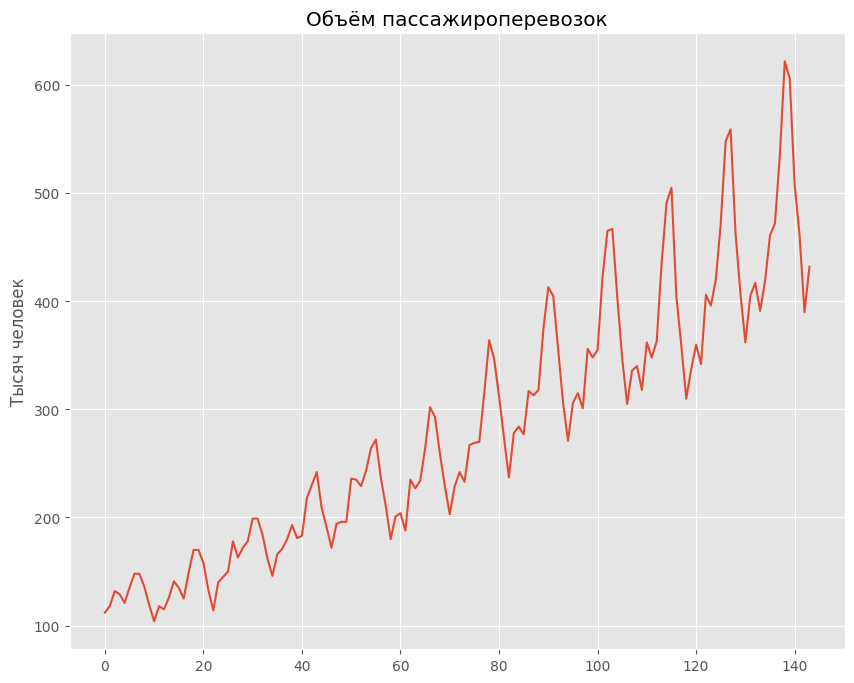

In [102]:
fig = plt.figure(figsize=(22, 8))
ax1 = fig.add_subplot(121)
df['series_g'].plot(ax=ax1)                 # Строим график по столбцу series_g
ax1.set_title(u'Объём пассажироперевозок')  # Указываем название графика
ax1.set_ylabel(u'Тысяч человек')            # Подписываем ось y

Text(0, 0.5, 'log10 от тысяч человек')

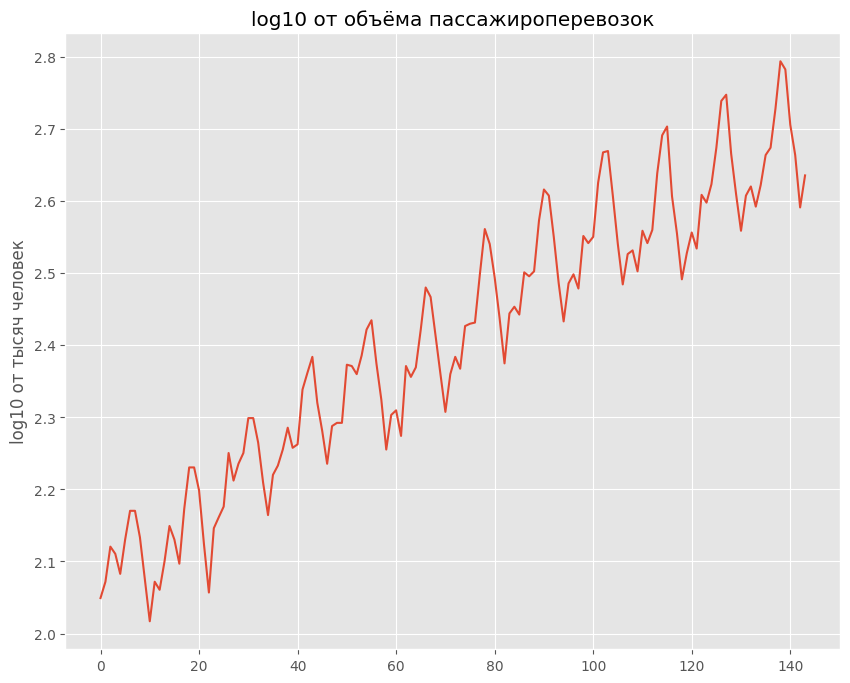

In [103]:
fig = plt.figure(figsize=(22, 8))
ax2 = fig.add_subplot(122)
pd.Series(np.log10(df['series_g'])).plot(ax=ax2)    # Логарифмируем, а замем строим график
ax2.set_title(u'log10 от объёма пассажироперевозок')
ax2.set_ylabel(u'log10 от тысяч человек')

Вывод: будем строить модель линейной регрессии для приближения логарифма от объёма перевозок. То есть
$$\log y_i = \beta x_i + c(x_i) + \varepsilon_i,$$
где $y_i$ -- объём перевозок, $x_i$ -- порядковый номер месяца, $c(x_i)$ -- сезонная составляющая, $\varepsilon_i$ -- случайный шум.

Для удобства дальнейшего использования создадим дополнительно 12 новых месяцев для построения прогноза на них. Для этого создадим эти 12 новых дат с помощью функции ```pd.date_range```. Данный объект будет объектом класса ```DateTimeIndex``` (наследованный от класса ```Index```), и чтобы объединить их с колонкой ```df['date']```, принадлежащей классу ```datetime64```, придётся привести последнюю к классу ```Index```. Объединим два набора дат и сохраним их в объекте ```new_dates```.

Далее создадим фиктивный датафрейм ```df2```, состоящий из одной колонки с этими новыми датами, и приклеим его к исходному датафрейму ```df``` с помозью функции ```pd.merge```. Эта функция склеивает два датасета по указанному набору колонок (параметр ```on```) и по указанному правилу склейки (параметр ```how```). В ```on``` указываем одну общую колонку ```date```, по которой нужно произвести склейку. В ```how``` указываем ```right```, что означает следующее: 
возьми весь правый датасет и приклей к нему левый датасет по условию совпадения значений колонки ```on```, а в случае если для значений из правой колонки ```on``` не найдётся соотвествующих значений в левой колонке ```on```, то тогда приклей ```NaN``` значения. Вообще говоря, опция ```how``` соответствует опциям ```JOIN``` в языке SQL (```LEFT JOIN```, ```RIGHT_JOIN```, ```INNER JOIN```, ```OUTER_JOIN```).

In [108]:
# Создаём последовательсть месяцев. freq='MS' означает первое число каждого месяца из указанного диапазона дат
new_dates = pd.date_range('1961-01-01', '1961-12-01', freq='MS')
# Приводим df['date'] к типу Index, объединяем с 12 месяцами, полученными на предыдущем шаге
new_dates = pd.Index(df['date']) | new_dates
# Создаём датафрейм из одной колонки с расширенным набором дат
df2 = pd.DataFrame({'date': new_dates})
# Объединяем два датафрейма по колонке 'date'.
df = pd.merge(df, df2, on='date', how='right')

/tmp/ipykernel_2009/811562972.py:4: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  new_dates = pd.Index(df['date']) | new_dates


Создадим регрессионную переменную ```month_num``` -- порядковый номер пары (месяц, год). И прологарифмируем таргет.

In [109]:
df['month_num'] = range(1, len(df) + 1)
df['log_y'] = np.log10(df['series_g'])

In [110]:
df.head()

,date,series_g,month_num,log_y
0,1949-01-01,112.0,1,2.049218
1,1949-02-01,118.0,2,2.071882
2,1949-03-01,132.0,3,2.120574
3,1949-04-01,129.0,4,2.110590
4,1949-05-01,121.0,5,2.082785


Создадим 12 колонок ```season_1```, ```season_2```, ..., ```season_12```, в которые поместим индикаторы соответствующего месяца. Чтобы достать порядковый номер месяца в каждой строчке, применим последовательно пару методов ```dt``` и ```month``` к колонке ```df['date']```. Внутри цикла будем проверять, равен ли очередной месяц текущему значению из цикла.

In [111]:
for x in range(1, 13):
    df['season_' + str(x)] = df['date'].dt.month == x

In [112]:
df.head()

,date,series_g,month_num,log_y,season_1,season_2,season_3,season_4,season_5,season_6,season_7,season_8,season_9,season_10,season_11,season_12
0,1949-01-01,112.0,1,2.049218,True,False,False,False,False,False,False,False,False,False,False,False
1,1949-02-01,118.0,2,2.071882,False,True,False,False,False,False,False,False,False,False,False,False
2,1949-03-01,132.0,3,2.120574,False,False,True,False,False,False,False,False,False,False,False,False
3,1949-04-01,129.0,4,2.110590,False,False,False,True,False,False,False,False,False,False,False,False
4,1949-05-01,121.0,5,2.082785,False,False,False,False,True,False,False,False,False,False,False,False


Правда, для устранения линейной зависимости между колонками, один из сезонных индикаторов придётся исключить. Пусть базовым месяцем будет январь.

In [115]:
# range(2, 13) соответствует всем месяцам с февраля по декабрь
season_columns = ['season_' + str(x) for x in range(2, 13)]

# Создадим объекты матрицу X и вектор y для обучения модели
X = df[['month_num'] + season_columns]
y = df['log_y']

# Оставим только те строчки, у которых известны значения y (с номером < 144)
X1 = X[X.index < 144]
y1 = y[y.index < 144]

Настраиваем линейную регрессионную модель.

In [116]:
model = LinearRegression()
model.fit(X1, y1)
# Создали и заполнили регрессионную модель данными

LinearRegression()

<AxesSubplot: >

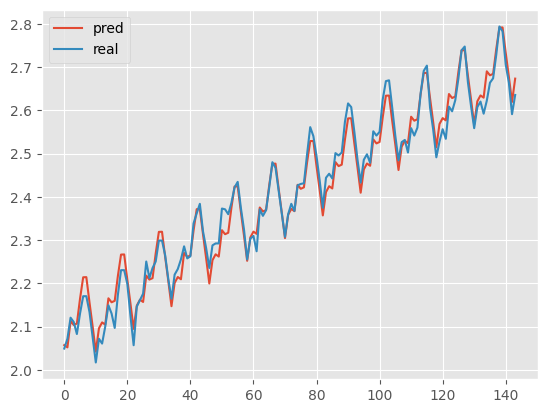

In [117]:
pred = pd.DataFrame({
    'pred': model.predict(X1),  # Предсказывем объем перевозок на обучающем мноожестве и сохраняем в DataFrame
    'real': y1})    # также сохраняем реальные значения
pred.plot()         # строим график, чтобы визуально оценить реальные показатели с предсказанными
# Видим, что модель довольно неплохо обучилась

Теперь построим предсказание для всей матрицы ```X```, включая неизвестные 12 месяцев.

<AxesSubplot: >

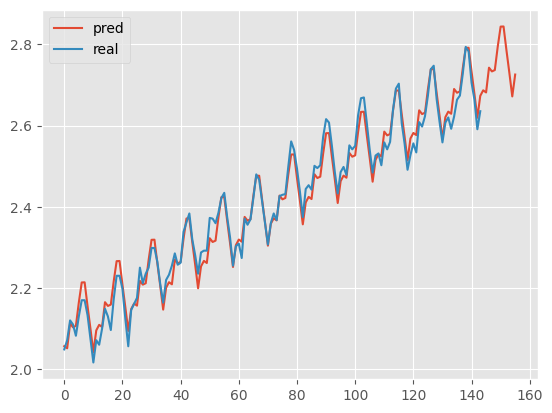

In [118]:
pred = pd.DataFrame({
    'pred': model.predict(X),   # Снова предсказываем объем перевозок, однако уже на полном наборе данных
    'real': y})                 # в данном случае в y присутствуют значения NaN
pred.plot()     # отобразим результаты
# получили прогноз за время, где у нас отсутствовали данные

<AxesSubplot: >

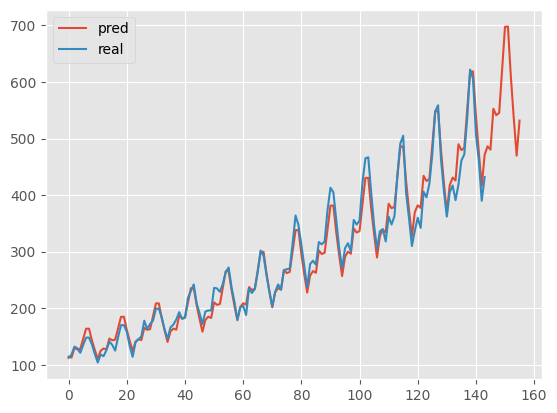

In [119]:
pred = pd.DataFrame({
    'pred': np.power(10, model.predict(X)), # вернмся к изначальным единицам, для этого возводим спрогнозированные результаты в 10 степень
    'real': df['series_g']})
pred.plot()
# получили прогноз за время, где у нас отсутствовали данные, только теперь в еденицах колонки series_g